In [1]:
import pandas as pd

In [357]:
report = pd.read_excel('2021 YTD Staffing History.xlsx', sheet_name='Individual_Staffing_8wk_report_')
report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39280 entries, 0 to 39279
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      39280 non-null  datetime64[ns]
 1   User                      39280 non-null  object        
 2   Client                    39280 non-null  object        
 3   Project                   39280 non-null  object        
 4   Project stage             39280 non-null  object        
 5   Booking type              39280 non-null  object        
 6   Booking                   39280 non-null  object        
 7   User Job code             39280 non-null  object        
 8   User Active               39280 non-null  object        
 9   User Department           38800 non-null  object        
 10  User Team                 38440 non-null  object        
 11  User User location        38320 non-null  object        
 12  Client Client Indu

In [358]:
perms = report[['User', 'Client', 'Project', 'Client Client Industry']].drop_duplicates().reset_index(drop=True)
perms

,User,Client,Project,Client Client Industry
0,"Abbas, Hadiqa","Novant Health, Inc.",Provider Solutions,Healthcare - Provider
1,"Abbas, Hadiqa",Humana,Tiered Networks Optimization,Healthcare - Payor
2,"Abbas, Hadiqa","Molina Healthcare, Inc.",CA Configuration,Healthcare - Payor
3,"Abbas, Hadiqa",Optima Health,QNXT Pre-Implementation,Healthcare - Payor
4,"Albrecht, Megan",Optima Health,Optima Health Sentara,Healthcare - Payor
...,...,...,...,...
940,"Zaruba, Suzanne","Health Net, Inc",CA Configuration Review,Healthcare - Payor
941,"Zaruba, Suzanne",Humana,Tiered Networks Optimization,Healthcare - Payor
942,"Zaruba, Suzanne","Molina Healthcare, Inc.",CA Configuration,Healthcare - Payor
943,"Zhou, Wei",Aetna Life Insurance Company,Analytics and Delivery Support,Healthcare - Payor


In [359]:
#perms['User'] = perms['User'].map(lambda x: x.split(', ')[1] + ' ' + x.split(', ')[0])

In [360]:
proj_groups = perms.groupby(['Project']).agg({'User': [pd.Series.nunique, lambda x: list(np.unique(x.values))]}).reset_index()
proj_groups.columns = proj_groups.columns.droplevel(0)
proj_groups = proj_groups.rename(columns={'':'Project', 'nunique': 'Num_Supporters', '<lambda_0>': 'Supporters'})
proj_groups = proj_groups.sort_values('Num_Supporters', ascending=False).reset_index(drop=True)

In [361]:
team_1 = set(proj_groups.loc[0, 'Supporters'])
team_2 = set(proj_groups.loc[1, 'Supporters'])
team_3 = set(proj_groups.loc[2, 'Supporters'])
team_4 = set(proj_groups.loc[3, 'Supporters'])
team_5 = set(proj_groups.loc[4, 'Supporters'])
team_6 = set(proj_groups.loc[5, 'Supporters'])

In [362]:
users = pd.get_dummies(perms.drop(columns='Project'), {'Client': '(CLIENT)', 'Client Client Industry': '(INDUSTRY)'}, prefix_sep=' ', columns=['Client', 'Client Client Industry']).groupby('User').sum()
users.shape

(209, 83)

# Find Unigrams

In [211]:
perms['Client'] = perms['Project'].str.replace(r'[^\w\s]','')

<ipython-input-211-8b4f6f965c56>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  perms['Client'] = perms['Project'].str.replace(r'[^\w\s]','')


In [191]:
from sklearn.feature_extraction.text import CountVectorizer

In [219]:
count_vec = CountVectorizer()
dtm = count_vec.fit_transform(perms['Project']).toarray()
top_10_unigrams = pd.DataFrame(dtm.sum(axis=0), index=count_vec.get_feature_names()).sort_values(0, ascending=False).iloc[:10]
top_10_unigrams

,0
support,144
cost,111
reduction,95
configuration,88
strategic,67
assessment,58
health,50
management,46
contracting,46
and,37


In [220]:
perms['Client'].value_counts()

Strategic Cost Reduction                      54
Configuration                                 30
Revenue Enhancement                           22
HBR Boost                                     18
Vendor Risk Assessment                        16
                                              ..
NonLabor Cost Reduction                        1
Med Rx Benefit Cost Reduction                  1
NonCapitated Spend                             1
School Age Data System                         1
Blackpool Bed Day Reduction Programme  LLC     1
Name: Client, Length: 135, dtype: int64

# Cluster

In [363]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [409]:
pca = PCA(n_components=2)
users_red = pca.fit_transform(users)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Intertia')

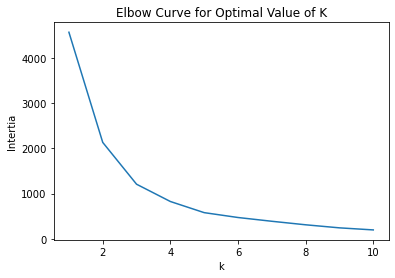

In [410]:
ks = [i for i in range(1, 11)]
inertias = []
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(users_red)
    inertias.append(km.inertia_)

sns.lineplot(ks, inertias)
plt.title('Elbow Curve for Optimal Value of K')
plt.xlabel('k')
plt.ylabel('Intertia')

In [415]:
km = KMeans(n_clusters=10)
km.fit(users)
users['Cluster'] = km.predict(users_red)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


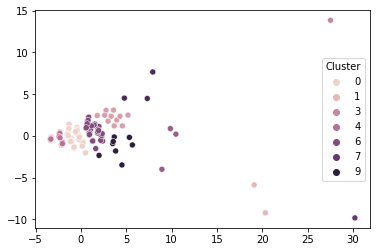

In [416]:
sns.scatterplot(users_red[:,0], users_red[:,1], hue=users['Cluster'])

In [417]:
users['Cluster'].value_counts()

4    76
0    70
6    34
2    11
9     8
5     3
8     3
1     2
3     1
7     1
Name: Cluster, dtype: int64

In [442]:
cluster_splits = []
for i in range(10):
    #exec(f"cluster_{i}_splits = [lst.tolist() for lst in np.array_split(list(users[users['Cluster'] == {i}].index), 6)]")
    cluster_splits.append([lst.tolist() for lst in np.array_split(list(users[users['Cluster'] == i].sample(frac=1).index), 6)])
# cluster_1_splits = [lst.tolist() for lst in np.array_split(list(users[users['Cluster'] == 1].index), 6)]
# cluster_2_splits = [lst.tolist() for lst in np.array_split(list(users[users['Cluster'] == 2].index), 6)]

In [444]:
teams = []
for i in range(6):
    team = []
    for split in cluster_splits:
        team += split[i]
    teams.append(team)
# for split_0, split_1, split_2 in cluster:
#     teams.append(split_0 + split_1 + split_2)

In [448]:
for ind, team in enumerate(teams):
    report.loc[report['User'].isin(team), 'Team from Clustering'] = ind + 1

In [449]:
report

,Date,User,Client,Project,Project stage,Booking type,Booking,User Job code,User Active,User Department,...,User User location,Client Client Industry,Project End Date,Project Project Location,Booking Notes,Booking End Date,Booking Start Date,All booked hours,Months,Team from Clustering
0,2021-01-03,"Abbas, Hadiqa","Novant Health, Inc.",Provider Solutions,In Progress,Confirmed,08/12/2021 to 10/11/2021 for 100% of the time,Senior Consultant,Yes,Field,...,Chicago,Healthcare - Provider,2021-10-11,North Carolina,NaN,2021-10-11,2021-08-12,0.0,January,2.0
1,2021-01-10,"Abbas, Hadiqa","Novant Health, Inc.",Provider Solutions,In Progress,Confirmed,08/12/2021 to 10/11/2021 for 100% of the time,Senior Consultant,Yes,Field,...,Chicago,Healthcare - Provider,2021-10-11,North Carolina,NaN,2021-10-11,2021-08-12,0.0,January,2.0
2,2021-01-17,"Abbas, Hadiqa","Novant Health, Inc.",Provider Solutions,In Progress,Confirmed,08/12/2021 to 10/11/2021 for 100% of the time,Senior Consultant,Yes,Field,...,Chicago,Healthcare - Provider,2021-10-11,North Carolina,NaN,2021-10-11,2021-08-12,0.0,January,2.0
3,2021-01-24,"Abbas, Hadiqa","Novant Health, Inc.",Provider Solutions,In Progress,Confirmed,08/12/2021 to 10/11/2021 for 100% of the time,Senior Consultant,Yes,Field,...,Chicago,Healthcare - Provider,2021-10-11,North Carolina,NaN,2021-10-11,2021-08-12,0.0,January,2.0
4,2021-01-31,"Abbas, Hadiqa","Novant Health, Inc.",Provider Solutions,In Progress,Confirmed,08/12/2021 to 10/11/2021 for 100% of the time,Senior Consultant,Yes,Field,...,Chicago,Healthcare - Provider,2021-10-11,North Carolina,NaN,2021-10-11,2021-08-12,0.0,January,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39275,2021-09-05,"Zhou, Wei",Centene,Vendor Risk Assessment,In Progress,Confirmed,06/07/2021 to 09/08/2021 for 100% of the time,Analyst,Yes,Field,...,New York City,Healthcare - Payor,2021-11-19,Missouri,NaN,2021-09-08,2021-06-07,16.0,September,5.0
39276,2021-09-12,"Zhou, Wei",Centene,Vendor Risk Assessment,In Progress,Confirmed,06/07/2021 to 09/08/2021 for 100% of the time,Analyst,Yes,Field,...,New York City,Healthcare - Payor,2021-11-19,Missouri,NaN,2021-09-08,2021-06-07,0.0,September,5.0
39277,2021-09-19,"Zhou, Wei",Centene,Vendor Risk Assessment,In Progress,Confirmed,06/07/2021 to 09/08/2021 for 100% of the time,Analyst,Yes,Field,...,New York City,Healthcare - Payor,2021-11-19,Missouri,NaN,2021-09-08,2021-06-07,0.0,September,5.0
39278,2021-09-26,"Zhou, Wei",Centene,Vendor Risk Assessment,In Progress,Confirmed,06/07/2021 to 09/08/2021 for 100% of the time,Analyst,Yes,Field,...,New York City,Healthcare - Payor,2021-11-19,Missouri,NaN,2021-09-08,2021-06-07,0.0,September,5.0


In [450]:
report.to_excel('assignments.xlsx', index=False)